# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:08 - loss: 0.6945

  25/1875 [..............................] - ETA: 4s - loss: 0.5697   

  53/1875 [..............................] - ETA: 3s - loss: 0.4809

  88/1875 [>.............................] - ETA: 3s - loss: 0.4261

 119/1875 [>.............................] - ETA: 3s - loss: 0.3972

 150/1875 [=>............................] - ETA: 2s - loss: 0.3766

 187/1875 [=>............................] - ETA: 2s - loss: 0.3581

 212/1875 [==>...........................] - ETA: 2s - loss: 0.3479

 246/1875 [==>...........................] - ETA: 2s - loss: 0.3360

 278/1875 [===>..........................] - ETA: 2s - loss: 0.3265

 311/1875 [===>..........................] - ETA: 2s - loss: 0.3180

 343/1875 [====>.........................] - ETA: 2s - loss: 0.3106

 380/1875 [=====>........................] - ETA: 2s - loss: 0.3031

 413/1875 [=====>........................] - ETA: 2s - loss: 0.2970

 444/1875 [======>.......................] - ETA: 2s - loss: 0.2918

 474/1875 [======>.......................] - ETA: 2s - loss: 0.2872

 502/1875 [=======>......................] - ETA: 2s - loss: 0.2832

 523/1875 [=======>......................] - ETA: 2s - loss: 0.2803

 551/1875 [=======>......................] - ETA: 2s - loss: 0.2767

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2733

 615/1875 [========>.....................] - ETA: 2s - loss: 0.2693

 647/1875 [=========>....................] - ETA: 2s - loss: 0.2659

 673/1875 [=========>....................] - ETA: 2s - loss: 0.2633

 701/1875 [==========>...................] - ETA: 1s - loss: 0.2606

 728/1875 [==========>...................] - ETA: 1s - loss: 0.2581

 759/1875 [===========>..................] - ETA: 1s - loss: 0.2554

 788/1875 [===========>..................] - ETA: 1s - loss: 0.2530

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2512

 838/1875 [============>.................] - ETA: 1s - loss: 0.2491

 865/1875 [============>.................] - ETA: 1s - loss: 0.2471

 893/1875 [=============>................] - ETA: 1s - loss: 0.2451

 923/1875 [=============>................] - ETA: 1s - loss: 0.2430

 955/1875 [==============>...............] - ETA: 1s - loss: 0.2409

 986/1875 [==============>...............] - ETA: 1s - loss: 0.2390

1016/1875 [===============>..............] - ETA: 1s - loss: 0.2371

1044/1875 [===============>..............] - ETA: 1s - loss: 0.2355

1072/1875 [================>.............] - ETA: 1s - loss: 0.2339

1098/1875 [================>.............] - ETA: 1s - loss: 0.2324

1127/1875 [=================>............] - ETA: 1s - loss: 0.2309

1150/1875 [=================>............] - ETA: 1s - loss: 0.2297

1179/1875 [=================>............] - ETA: 1s - loss: 0.2282

1211/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1241/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1270/1875 [===================>..........] - ETA: 1s - loss: 0.2239

1302/1875 [===================>..........] - ETA: 0s - loss: 0.2224

1337/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1373/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1405/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1438/1875 [======================>.......] - ETA: 0s - loss: 0.2168

1475/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1510/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2127

1580/1875 [========================>.....] - ETA: 0s - loss: 0.2115

1618/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1654/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1689/1875 [==========================>...] - ETA: 0s - loss: 0.2079

1716/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1773/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1803/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1834/1875 [============================>.] - ETA: 0s - loss: 0.2034

1869/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2022


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1058

  29/1875 [..............................] - ETA: 3s - loss: 0.1072

  61/1875 [..............................] - ETA: 3s - loss: 0.1075

  93/1875 [>.............................] - ETA: 2s - loss: 0.1077

 120/1875 [>.............................] - ETA: 3s - loss: 0.1079

 145/1875 [=>............................] - ETA: 3s - loss: 0.1080

 173/1875 [=>............................] - ETA: 3s - loss: 0.1081

 203/1875 [==>...........................] - ETA: 2s - loss: 0.1081

 238/1875 [==>...........................] - ETA: 2s - loss: 0.1081

 275/1875 [===>..........................] - ETA: 2s - loss: 0.1081

 306/1875 [===>..........................] - ETA: 2s - loss: 0.1080

 328/1875 [====>.........................] - ETA: 2s - loss: 0.1080

 354/1875 [====>.........................] - ETA: 2s - loss: 0.1080

 381/1875 [=====>........................] - ETA: 2s - loss: 0.1080

 412/1875 [=====>........................] - ETA: 2s - loss: 0.1079

 448/1875 [======>.......................] - ETA: 2s - loss: 0.1079

 482/1875 [======>.......................] - ETA: 2s - loss: 0.1078

 514/1875 [=======>......................] - ETA: 2s - loss: 0.1077

 549/1875 [=======>......................] - ETA: 2s - loss: 0.1076

 582/1875 [========>.....................] - ETA: 2s - loss: 0.1076

 612/1875 [========>.....................] - ETA: 2s - loss: 0.1075

 647/1875 [=========>....................] - ETA: 2s - loss: 0.1074

 683/1875 [=========>....................] - ETA: 1s - loss: 0.1074

 719/1875 [==========>...................] - ETA: 1s - loss: 0.1073

 751/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 782/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 816/1875 [============>.................] - ETA: 1s - loss: 0.1071

 850/1875 [============>.................] - ETA: 1s - loss: 0.1071

 885/1875 [=============>................] - ETA: 1s - loss: 0.1070

 918/1875 [=============>................] - ETA: 1s - loss: 0.1069

 950/1875 [==============>...............] - ETA: 1s - loss: 0.1069

 979/1875 [==============>...............] - ETA: 1s - loss: 0.1068

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1040/1875 [===============>..............] - ETA: 1s - loss: 0.1067

1075/1875 [================>.............] - ETA: 1s - loss: 0.1067

1106/1875 [================>.............] - ETA: 1s - loss: 0.1066

1134/1875 [=================>............] - ETA: 1s - loss: 0.1066

1163/1875 [=================>............] - ETA: 1s - loss: 0.1065

1197/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1230/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1258/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1292/1875 [===================>..........] - ETA: 0s - loss: 0.1063

1322/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1353/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1375/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1403/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1434/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1465/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1532/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1560/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1589/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1654/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1682/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1710/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1741/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1772/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1807/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1840/1875 [============================>.] - ETA: 0s - loss: 0.1054

1873/1875 [============================>.] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0990

  36/1875 [..............................] - ETA: 2s - loss: 0.0987

  71/1875 [>.............................] - ETA: 2s - loss: 0.0988

 101/1875 [>.............................] - ETA: 2s - loss: 0.0985

 128/1875 [=>............................] - ETA: 2s - loss: 0.0985

 160/1875 [=>............................] - ETA: 2s - loss: 0.0984

 193/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0982

 260/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 406/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0981

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 619/1875 [========>.....................] - ETA: 1s - loss: 0.0981

 654/1875 [=========>....................] - ETA: 1s - loss: 0.0981

 690/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 727/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 760/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 824/1875 [============>.................] - ETA: 1s - loss: 0.0980

 851/1875 [============>.................] - ETA: 1s - loss: 0.0980

 879/1875 [=============>................] - ETA: 1s - loss: 0.0980

 908/1875 [=============>................] - ETA: 1s - loss: 0.0980

 936/1875 [=============>................] - ETA: 1s - loss: 0.0980

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1076/1875 [================>.............] - ETA: 1s - loss: 0.0979

1110/1875 [================>.............] - ETA: 1s - loss: 0.0979

1138/1875 [=================>............] - ETA: 1s - loss: 0.0979

1167/1875 [=================>............] - ETA: 1s - loss: 0.0979

1196/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1288/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1318/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1349/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1815/1875 [============================>.] - ETA: 0s - loss: 0.0978

1849/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0893

  23/1875 [..............................] - ETA: 4s - loss: 0.0954

  58/1875 [..............................] - ETA: 3s - loss: 0.0962

  91/1875 [>.............................] - ETA: 3s - loss: 0.0963

 120/1875 [>.............................] - ETA: 2s - loss: 0.0964

 153/1875 [=>............................] - ETA: 2s - loss: 0.0963

 189/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 222/1875 [==>...........................] - ETA: 2s - loss: 0.0964

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 683/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 714/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 747/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 808/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 841/1875 [============>.................] - ETA: 1s - loss: 0.0962

 872/1875 [============>.................] - ETA: 1s - loss: 0.0962

 904/1875 [=============>................] - ETA: 1s - loss: 0.0962

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0962

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1080/1875 [================>.............] - ETA: 1s - loss: 0.0962

1113/1875 [================>.............] - ETA: 1s - loss: 0.0961

1150/1875 [=================>............] - ETA: 1s - loss: 0.0961

1183/1875 [=================>............] - ETA: 1s - loss: 0.0961

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1252/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1274/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1302/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1330/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1358/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1841/1875 [============================>.] - ETA: 0s - loss: 0.0961

1873/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0925

  32/1875 [..............................] - ETA: 3s - loss: 0.0945

  64/1875 [>.............................] - ETA: 2s - loss: 0.0949

  95/1875 [>.............................] - ETA: 2s - loss: 0.0951

 129/1875 [=>............................] - ETA: 2s - loss: 0.0952

 163/1875 [=>............................] - ETA: 2s - loss: 0.0952

 194/1875 [==>...........................] - ETA: 2s - loss: 0.0952

 230/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 266/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0951

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0951

 464/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 568/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 595/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 634/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 667/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 700/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 731/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 760/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 822/1875 [============>.................] - ETA: 1s - loss: 0.0951

 858/1875 [============>.................] - ETA: 1s - loss: 0.0952

 888/1875 [=============>................] - ETA: 1s - loss: 0.0952

 920/1875 [=============>................] - ETA: 1s - loss: 0.0952

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1081/1875 [================>.............] - ETA: 1s - loss: 0.0952

1111/1875 [================>.............] - ETA: 1s - loss: 0.0952

1146/1875 [=================>............] - ETA: 1s - loss: 0.0952

1181/1875 [=================>............] - ETA: 1s - loss: 0.0952

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1252/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1282/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1314/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1345/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1829/1875 [============================>.] - ETA: 0s - loss: 0.0953

1857/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

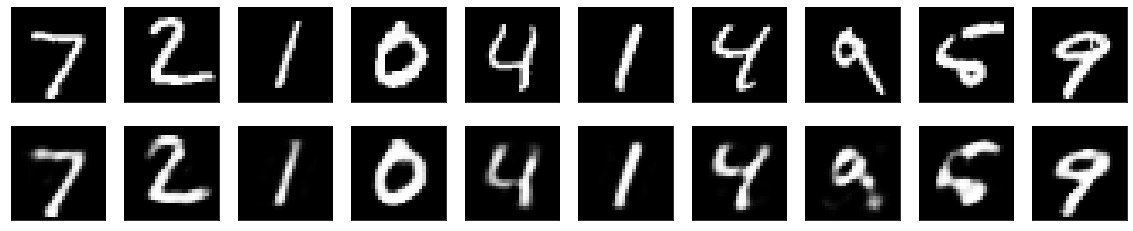

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
